In [1]:
# Author: Brandon Botzer
# Date: 2/07/2024
# Class: Penn State - AI 879

Perform a watershed segmentation on the L06 sunflower.png Download L06 sunflower.png to detect the sunflowers.

You may also use an image of your choice with the proper citation.

Please consult “Marker-Controlled Watershed Segmentation” page at https://www.mathworks.com/help/images/marker-controlled-watershed-segmentation.htmlLinks to an external site.

Please explain how watershed works and justify the results.

# Introduction

I will attempt to apply a watershed implementation from a number of different steps of preprocessing.

First, I will find the gradients of the image and try to apply a watershed.  This will be met with no success.

I will then find local peaks within the image and use them as label regions for the watershed.  This will at least find some regions, but will not do a great job to identify the sunflowers.

I will then try to use the gradients with a structural element (footprint) and create markers from regions where the gradient is at some threshold.  This will work better, but still won't find just flowers.

Lastly, I will follow https://www.mathworks.com/help/images/marker-controlled-watershed-segmentation.html and preprocess the image.  I do this up until the creation of a second gradient magnitude where minimums are imposed on localized watershed regions.  While matlab has a specific function to do this (imimposemin), skimage does not.  However, using the preprocessed image to generate proper marker regions and then applying the watershed segmentation from prior methods does allow many sunflowers to be properly identified.

Per their page:

Marker-Controlled Watershed Segmentation

This example shows how to use watershed segmentation to separate touching objects in an image. The watershed transform finds "catchment basins" and "watershed ridge lines" in an image by treating it as a surface where light pixels are high and dark pixels are low.

Segmentation using the watershed transform works better if you can identify, or "mark," foreground objects and background locations. Marker-controlled watershed segmentation follows this basic procedure:

1. Compute a segmentation function. This is an image whose dark regions are the objects you are trying to segment.

2. Compute foreground markers. These are connected blobs of pixels within each of the objects.

3. Compute background markers. These are pixels that are not part of any object.

4. Modify the segmentation function so that it only has minima at the foreground and background marker locations.

5. Compute the watershed transform of the modified segmentation function.



In [2]:
# Imports for functions

# The scikit-image package provides a wide variety of filter applications
#  which reduce the need to write out the corr / conv matricies

from PIL import Image

import skimage as ski
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

# Fast sorting and coputations
import scipy as sci
from scipy.spatial.distance import cdist
from scipy.ndimage import distance_transform_edt, label
# Showing the results of scipy computations
import pandas as pd

cv.__version__, ski.__version__

('4.8.1', '0.22.0')

Get the image and look at it

In [3]:
# Image from: https://www.istockphoto.com/photo/close-up-of-a-bunch-of-ripe-red-apples-gm115684139-943649

# image = ski.io.imread('bunch-of-apples.jpg')
image = ski.io.imread('L06 sunflower.png')

In [4]:
image.shape

(594, 960, 3)

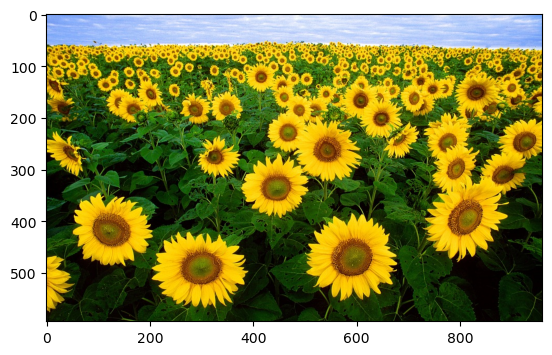

In [5]:
plt.imshow(image)

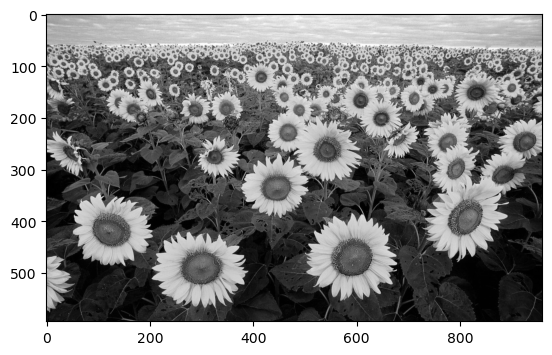

In [6]:
# Convert to grayscale
imblk = ski.color.rgb2gray(image)
plt.imshow(imblk, cmap='gray')

# Applying the Watershed to just the gradients of the image

c:\Users\btb51\anaconda3\envs\ai879_basic\Lib\site-packages\IPython\core\interactiveshell.py:3553: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


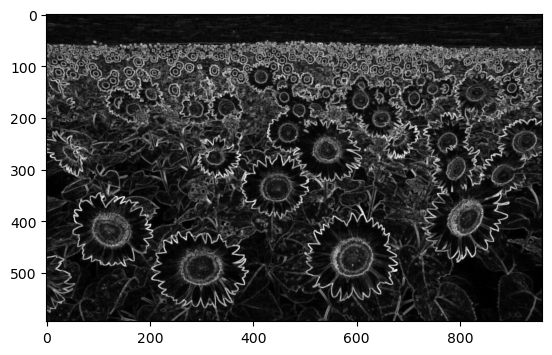

In [7]:
# Calculate the gradient of the grayscale image
grad = ski.filters.rank.gradient(imblk, footprint=np.ones((3,3)))
plt.imshow(grad, cmap='gray')

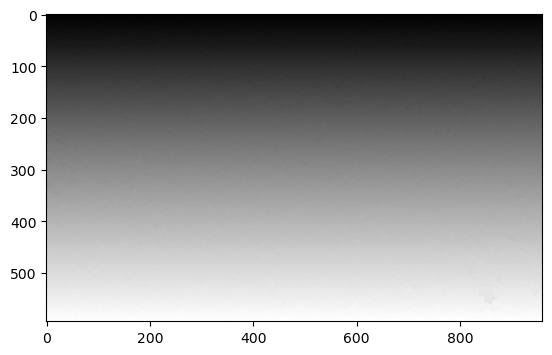

In [8]:
# Testing to see if you can run a watershed on just the gradients
#  You can't... more preprocessing is requried
water_test = ski.segmentation.watershed(grad)
plt.imshow(water_test, cmap='gray')

This does not work.  Let us try applying some markers in the image by calculating the peak_local_max().

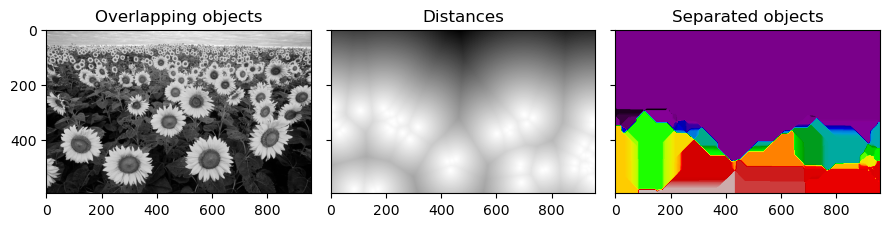

In [9]:
# Modified from the Skimage tutorial: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html

# Generate the markers as local maxima of the distance to the background
distance = distance_transform_edt(imblk)

# The peak_local_max function can also take a 'labels' argument.  I do not here as there is array casting error.
# I think not including the labels=imblk could be causing issues
coords = ski.feature.peak_local_max(distance, footprint=np.ones((3, 3)))  #, labels=imblk)

# Generate an array the shape of the distance measurements
mask = np.zeros(distance.shape, dtype=bool)
# Transpose the coords into a proper listing of x,y coords
mask[tuple(coords.T)] = True
# apply the ndimage.label function to classify each connected mask area as a region
markers, _ = label(mask)
# Over each labeled region (the markers), use the complement (invert) of the distance image on the grayscale image
labels = ski.segmentation.watershed(ski.util.invert(distance), markers, mask=imblk)

# Plot it all out, the grayscale image, the distance invertion, and the labels created by the watershed
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(imblk, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')


fig.tight_layout()
plt.show()

This is better, but still is not finding the sunflowers properly.  This is probably because the sunflowers themselves are a circular region of local peaks which may make the markers not as useful.

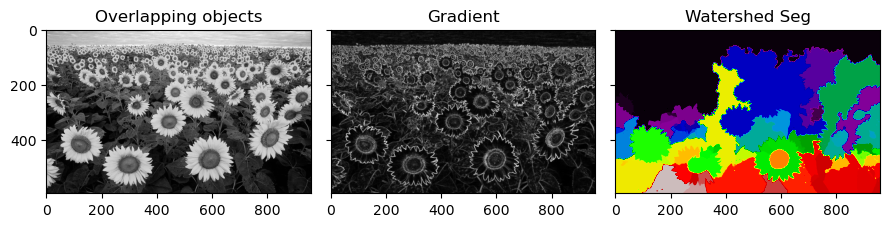

In [10]:
# Modified from the Skimage tutorial: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html

# Generate the markers as local maxima of the distance to the background
distance = distance_transform_edt(imblk)

# The peak_local_max function can also take a 'labels' argument.  I do not here as there is array casting error.
# I think not including the labels=imblk could be causing issues
coords = ski.feature.peak_local_max(distance, footprint=np.ones((3, 3)))  #, labels=imblk)

# Generate an array the shape of the distance measurements
mask = np.zeros(distance.shape, dtype=bool)
# Transpose the coords into a proper listing of x,y coords
mask[tuple(coords.T)] = True
# apply the ndimage.label function to classify each connected mask area as a region
markers, _ = label(mask)
# Over each labeled region (the markers), use the complement (invert) of the distance image on the grayscale image
labels = ski.segmentation.watershed(grad, markers, mask=imblk)

# Plot it all out, the grayscale image, the distance invertion, and the labels created by the watershed
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(imblk, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(grad, cmap=plt.cm.gray)
ax[1].set_title('Gradient')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Watershed Seg')

fig.tight_layout()
plt.show()

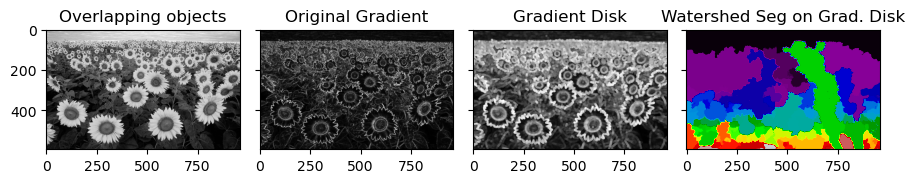

In [11]:
# Apply gradient-based segmentation using a disk structural element (footprint)
#  This differs slightly from how I found the last gradient
grad_disk = ski.filters.rank.gradient(imblk, ski.morphology.disk(5))

# Create markers based on a a threshold from the gradient
markers = label(grad_disk < 10)[0]
# Apply the watershed on the gradient_disk using the set markers
labels = ski.segmentation.watershed(grad_disk, markers, mask=imblk)

# Plot it all out, the grayscale image, the distance invertion, and the labels created by the watershed
fig, axes = plt.subplots(ncols=4, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

# Display the results
ax[0].imshow(imblk, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(grad, cmap=plt.cm.gray)
ax[1].set_title('Original Gradient')
ax[2].imshow(grad_disk, cmap=plt.cm.gray)
ax[2].set_title('Gradient Disk')
ax[3].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[3].set_title('Watershed Seg on Grad. Disk')

fig.tight_layout()
plt.show()


The watershed changed this time but I modified two things, the gradient (to a disk structural element) and how I created the markers.

I will now use the old markers, with the new Gradient Disk.

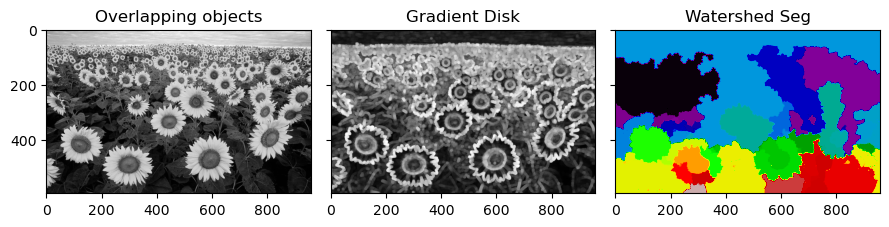

In [12]:
# Using the old markers via peak_local process with the gradient_disk

# Modified from the Skimage tutorial: https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_watershed.html

# Generate the markers as local maxima of the distance to the background
distance = distance_transform_edt(imblk)

# The peak_local_max function can also take a 'labels' argument.  I do not here as there is array casting error.
# I think not including the labels=imblk could be causing issues
coords = ski.feature.peak_local_max(distance, footprint=np.ones((3, 3)))  #, labels=imblk)

# Generate an array the shape of the distance measurements
mask = np.zeros(distance.shape, dtype=bool)
# Transpose the coords into a proper listing of x,y coords
mask[tuple(coords.T)] = True
# apply the ndimage.label function to classify each connected mask area as a region
markers, _ = label(mask)
# Over each labeled region (the markers), use the complement (invert) of the distance image on the grayscale image
labels = ski.segmentation.watershed(grad_disk, markers, mask=imblk)

# Plot it all out, the grayscale image, the distance invertion, and the labels created by the watershed
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(imblk, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(grad_disk, cmap=plt.cm.gray)
ax[1].set_title('Gradient Disk')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Watershed Seg')


fig.tight_layout()
plt.show()

And here are the new markers (via grad_disk) but using the old gradient image for the watershed.

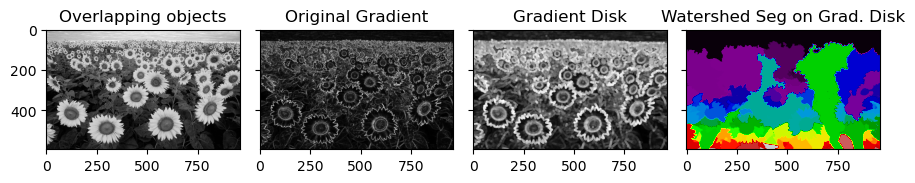

In [13]:
# Apply gradient-based segmentation using a disk structural element (footprint)
#  This differs slightly from how I found the last gradient
grad_disk = ski.filters.rank.gradient(imblk, ski.morphology.disk(5))

# Create markers based on a a threshold from the gradient
markers = label(grad_disk < 10)[0]
# Apply the watershed on the original gradient using the set markers
labels = ski.segmentation.watershed(grad, markers, mask=imblk)

# Plot it all out, the grayscale image, the distance invertion, and the labels created by the watershed
fig, axes = plt.subplots(ncols=4, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

# Display the results
ax[0].imshow(imblk, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(grad, cmap=plt.cm.gray)
ax[1].set_title('Original Gradient')
ax[2].imshow(grad_disk, cmap=plt.cm.gray)
ax[2].set_title('Gradient Disk')
ax[3].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[3].set_title('Watershed Seg on Grad. Disk')

fig.tight_layout()
plt.show()

We see no mater what, we are getting some segmentation, but it is unlikely that we are pulling out individual sunflowers.  Instead, we are pulling out large regions.

I will now apply a large amound of preprocessing, as per: https://www.mathworks.com/help/images/marker-controlled-watershed-segmentation.html and then apply the watershed segmentation.

# Applying Preprocessing as per Matlab Demo

I will skip steps 1 and 2 here as they pertain to reading the file and converting to grayscale, which has already been done.

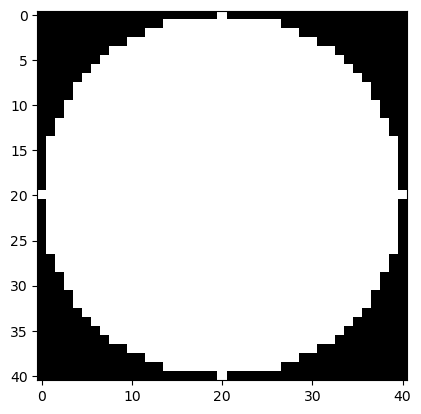

In [14]:
# Step 3: Mark the foreground objects

# Create the disc structuring element (footprint in skimage)
struct_el = ski.morphology.disk(20)
plt.imshow(struct_el, cmap='gray')

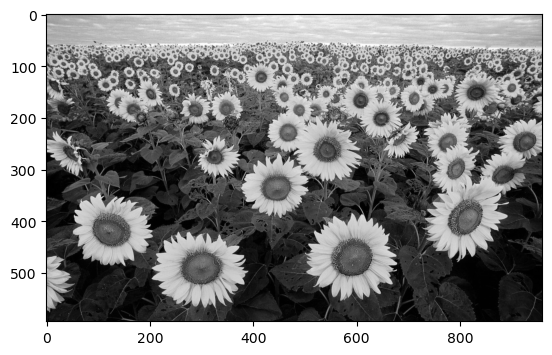

In [15]:
# Show the grayscale image again for comparison
plt.imshow(imblk, cmap='gray')

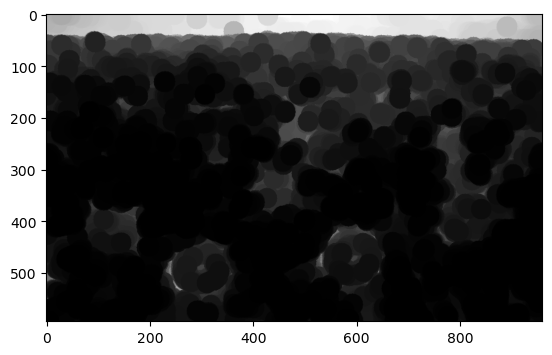

In [16]:
# Apply an Erosion to the grayscale image
eros_im = ski.morphology.erosion(imblk, struct_el)
plt.imshow(eros_im, cmap='gray')

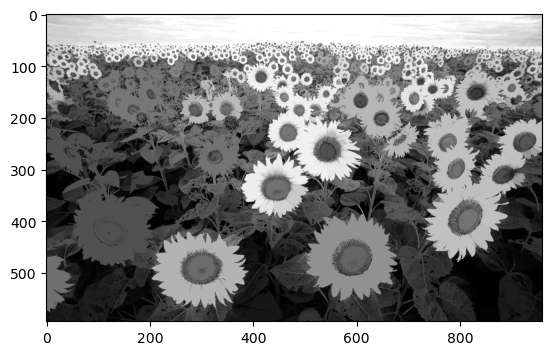

In [17]:
# Apply a Morphological Reconstruction by dilation to the eroded image
morph_recon = ski.morphology.reconstruction(eros_im, imblk)
plt.imshow(morph_recon, cmap='gray')

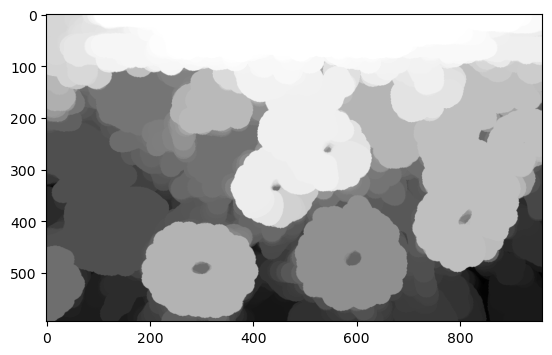

In [18]:
# Follow with a closing-by-reconstruction

# This is a dilate followed by a reconstruct

# Apply the dilation (this expands the sunflower petals)
dilate_im = ski.morphology.dilation(morph_recon, struct_el)
plt.imshow(dilate_im, cmap='gray')

To reconstruct the image, the complement (invert) of the dilated image must be used.  Not using it throws the following error:

In [19]:
# Reconstruction without using the compliment (inversion) throws an error
morphtest_recon = ski.morphology.reconstruction(dilate_im, morph_recon)
plt.imshow(morphtest_recon, cmap='gray')

ValueError: Intensity of seed image must be less than that of the mask image for reconstruction by dilation.

Using the complement of the dilated image for the reconstruction:

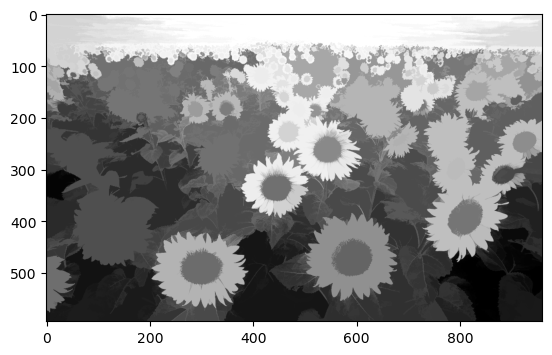

In [20]:
# Reconstruction using the compliment (invert)
morph2_recon = ski.morphology.reconstruction(ski.util.invert(dilate_im), ski.util.invert(morph_recon))
# re-invert the image
morph2_recon_inv = ski.util.invert(morph2_recon)
plt.imshow(morph2_recon_inv, cmap='gray')


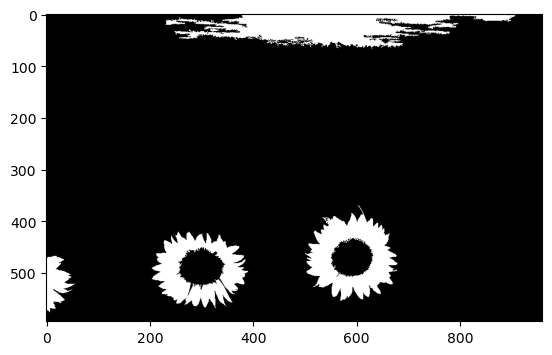

In [21]:
# Calculate the regional maxima to find the foreground markers
foreground_markers = ski.morphology.local_maxima(morph2_recon_inv)
plt.imshow(foreground_markers, cmap='gray')


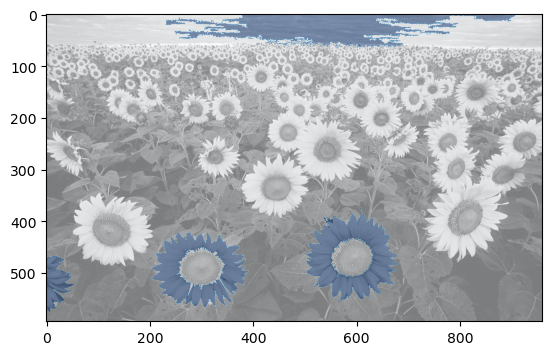

In [22]:
# Show the overlay of the foreground markers to the grayscale image itself

fig, ax = plt.subplots()
# Plot original grayscale image
ax.imshow(imblk, cmap='gray')
# Plot the forground markers on top
ax.imshow(foreground_markers, alpha=0.5, cmap='Blues')
plt.show()

We see here that we are begining to discover the sunflowers themselves.  Though we only have two and a half of them in the lower region of the picture.  We've also marked a clear region of the background as foreground which is non-optimal.

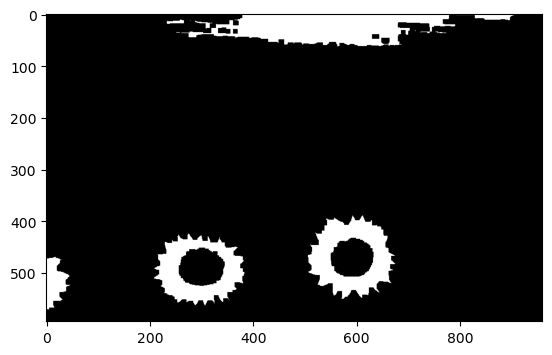

In [23]:
# Clean up the edges of the marker blobs

# This is done with a closing followed by an erosion

# Create a new square structing element (footprint)
struct_el2 = ski.morphology.square(5)

# Perform a closing
foreground_markers2 = ski.morphology.closing(foreground_markers, struct_el2)

# Perform an erosion
foreground_markers3 = ski.morphology.erosion(foreground_markers2, struct_el2)

plt.imshow(foreground_markers3, cmap='gray')

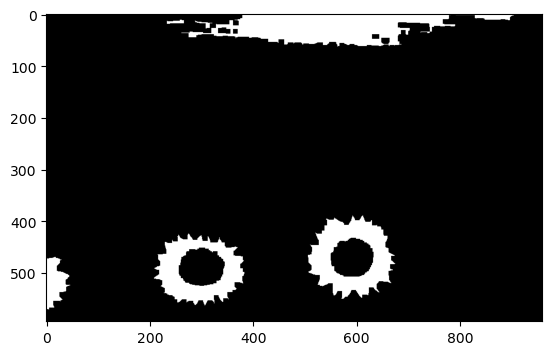

In [24]:
# If there are stray isolated pixels, they can be removed with an area_open

foreground_markers4 = ski.morphology.area_opening(foreground_markers3, area_threshold=30, connectivity=2)

plt.imshow(foreground_markers4, cmap='gray')

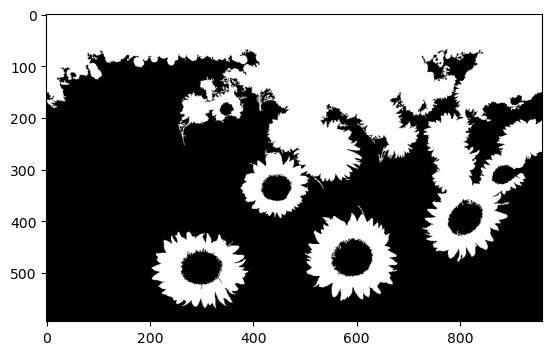

In [25]:
# Now we must compute the background markers

# While there are many ways to do thresholding, I will use Otsu's method to minimize intra-class variance.
# This is the same method that Matlab uses by default

thresh_otsu = ski.filters.threshold_otsu(morph2_recon_inv)

bw = morph2_recon_inv > thresh_otsu

plt.imshow(bw, cmap='gray')

We have found even more sunflowers here.  But note, the the background here (the sky) has been masked out as well in a large region.

At this point, the Matlab instructions use a function known as imimposemin() to impose a minimum in each marker region.  The closest thing to this in an open-source package is using the morphological reconstruction from skimage, but it works differently and does not behave well.  As such, begin taking distances transforms and seeing what I can do from there.

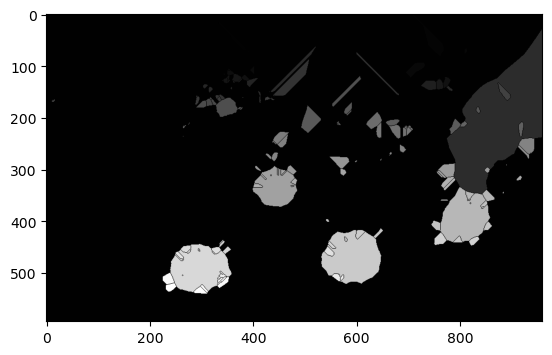

In [26]:
# This cell is where the Matlab walkthrough ends and I diverge


# Thin the background by computing the 'skeleton of inclunce zones' SKIZ.

# Do this by computing the watershed transform of the bw image and then looking for the watershed ridge lines (DL==0) of the result.

# I am having trouble getting ski.morphology.reconstruction() to work the same way as matlabs imimposemin() function.

# Instead I try the following:

# Find the distances from peaks to null points
d = distance_transform_edt(bw)

# Run a watershed to find line regions - Make sure you return the lines or else you won't have regions that hit dl == 0
dl = ski.segmentation.watershed(d, watershed_line=True)
plt.imshow(dl, cmap='gray')


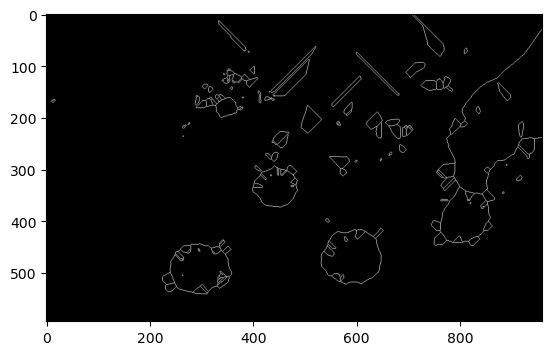

In [27]:
# Find the backgrond markers (the watershed lines)
bgm = dl == 0
plt.imshow(bgm, cmap='gray')


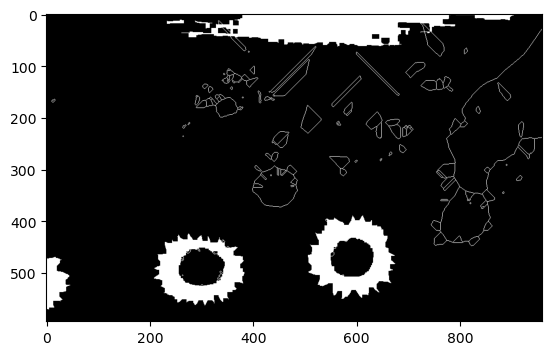

In [28]:
# Combine the background and foreground markers into one
comb_markers = bgm + foreground_markers4
# Convert the boolean image into a binary image (1/0)
comb_markers = ski.util.img_as_ubyte(comb_markers)
plt.imshow(comb_markers, cmap='gray')

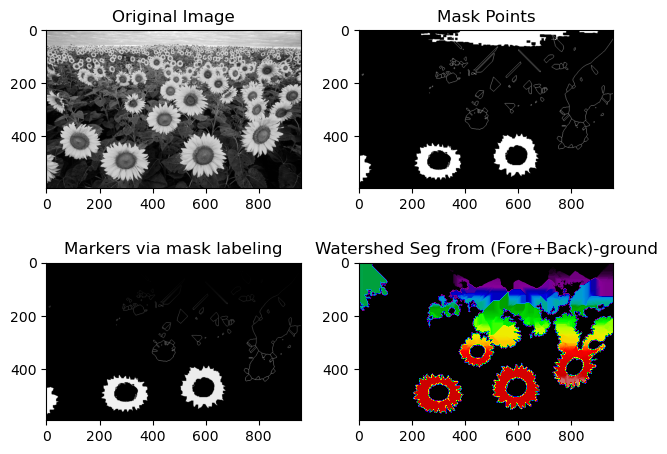

In [38]:
# Find coordinates for the peak_local_max based on the combined marker image
crds = ski.feature.peak_local_max(comb_markers, footprint = ski.morphology.square(3))
crds.shape

# Create a mask 2d array
mask = np.zeros(comb_markers.shape, dtype=bool)
# Take the coordinates from peak_local_max and cast them as x,y coords
mask[tuple(crds.T)] = True
# Create connected labels from the mask
markers, _ = label(mask)

# Note the inverted distance image (I speak on this later)
labels = ski.segmentation.watershed(ski.util.invert(comb_markers), markers, mask=bw)


# Plot it all out, the grayscale image, the mask, the markers, and the labels created by the watershed
fig, ax = plt.subplots(2,2)
plt.tight_layout()


ax[0,0].set_title('Original Image')
ax[0,0].imshow(imblk, cmap=plt.cm.gray)

ax[0,1].set_title('Mask Points')
ax[0,1].imshow(mask, cmap=plt.cm.gray)

ax[1,0].set_title('Markers via mask labeling')
ax[1,0].imshow(markers, cmap=plt.cm.gray)

ax[1,1].set_title('Watershed Seg from (Fore+Back)-ground')
ax[1,1].imshow(labels, cmap=plt.cm.nipy_spectral) # I would like some color now

Despite not being able to apply the last bit of Matlab methodology, the watershed above turned out well.  The markers did a good job of designating high and low points for the watershed and the markers allowed for basin regions.  It was interesting that as the basins filled, they joined into the larger structures in the top side (green, blue, purple) of the image.  This could have been adjusted if I could have refined the watershed 'mask' keyword parameter but the 'bw' image was as far as my preprocessing took me.  The watershed would only fill in areas in which the 'bw' plot was boolean true.

In [30]:
# I for the life of me can't get this to work...
#I don't even know if I'm able to as the bgm|foreground are boolean (which I could convert to binary) but those would still have a larger intensity than the grad
gmag2 = ski.morphology.reconstruction(bgm | foreground_markers4, grad)
plt.imshow(gmag2, cmap='gray')


ValueError: Intensity of seed image must be less than that of the mask image for reconstruction by dilation.

# Diverging from Matlab

Given the last bit of issue I had with the Matlab implementation, I decided to try some other ideas to see if I could obtain better (or at least different) results.

With the preprocessed image (bw) I'll now try to implement the process outlined by skimage.  This time, with bw being preprocessed, I may have a better chance of working through gradients and thresholds.

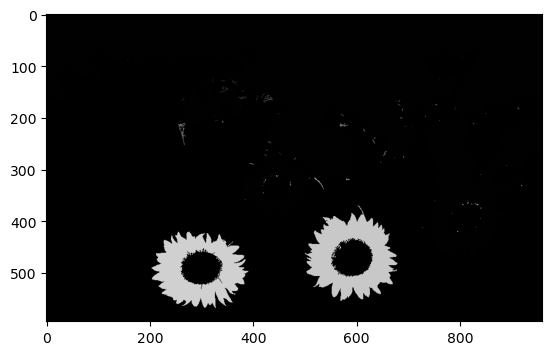

In [31]:
# I'll make labels of the conected regions of the bw image (I may not need these)
bw_labels, num_features = label(bw)
plt.imshow(bw_labels, cmap='gray')

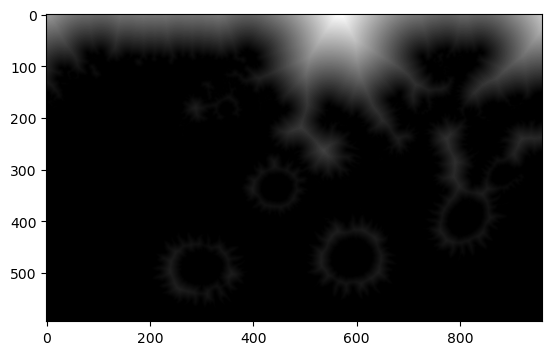

In [32]:
# What I'll do instead is use the distance transform based on the binarized image (which took lots of preprocessing to achieve)
#  This should give me a better chance to perform a better
dist_d = distance_transform_edt(bw)
plt.imshow(dist_d, cmap='gray')

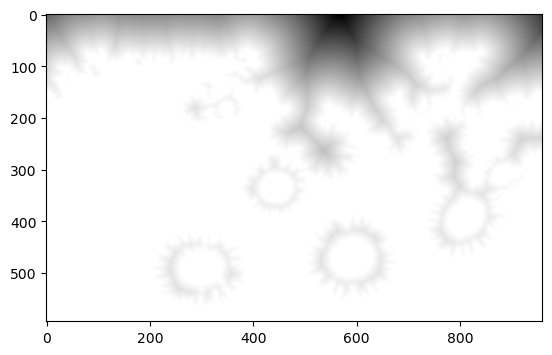

In [33]:
# What does the complement (invert) of the distance map look like?
plt.imshow(ski.util.invert(dist_d), cmap='gray')

 When I used just the bw image, I had poor results.  Inverting it gave me something better.

I found that some examples used the compliment (inversion) while some did not.  I used the inverted image for the comb_markers (fore and background) in the prior example as well.

Using the inversion: https://www.mathworks.com/help/images/ref/watershed.html

Not using the inversion: https://www.mathworks.com/help/images/marker-controlled-watershed-segmentation.html

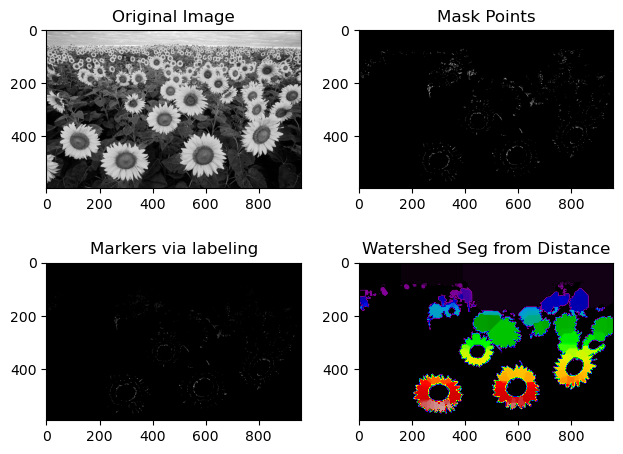

In [34]:
# Find coordinates for the peak_local_max based on the distance plot
crds = ski.feature.peak_local_max(dist_d, footprint = ski.morphology.square(3), labels=bw_labels)
crds.shape

# Create a mask 2d array
mask = np.zeros(dist_d.shape, dtype=bool)
# Take the coordinates from peak_local_max and cast them as x,y coords
mask[tuple(crds.T)] = True
# Create connected labels from the mask
markers, _ = label(mask)


# Note the inverted distance image
labels = ski.segmentation.watershed(ski.util.invert(dist_d), markers, mask=bw)


# Plot it all out, the grayscale image, the mask, the markers, and the labels created by the watershed
fig, ax = plt.subplots(2,2)
plt.tight_layout()


ax[0,0].set_title('Original Image')
ax[0,0].imshow(imblk, cmap=plt.cm.gray)

ax[0,1].set_title('Mask Points')
ax[0,1].imshow(mask, cmap=plt.cm.gray)

ax[1,0].set_title('Markers via labeling')
ax[1,0].imshow(markers, cmap=plt.cm.gray)

ax[1,1].set_title('Watershed Seg from Distance')
ax[1,1].imshow(labels, cmap=plt.cm.nipy_spectral) # I would like some color now

Finally we are starting to see some segmentation on the flowers.  How will the results change if I use the gradient image instead of the distance image?

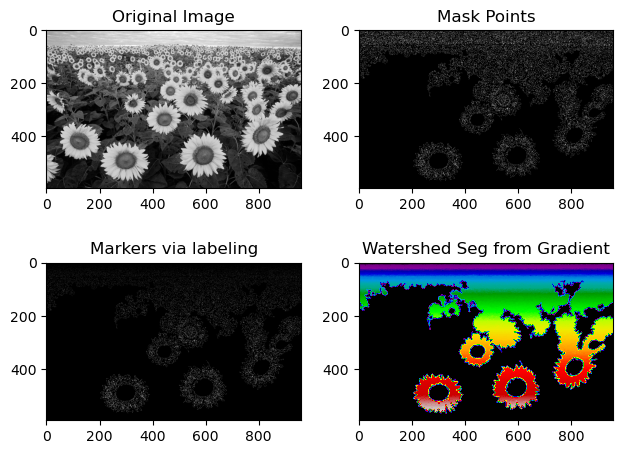

In [35]:
# Find coordinates for the peak_local_max based on the gradient plot
crds = ski.feature.peak_local_max(grad, footprint = ski.morphology.square(3), labels=bw_labels)

# Create a mask 2d array
mask = np.zeros(grad.shape, dtype=bool)
# Take the coordinates from peak_local_max and cast them as x,y coords
mask[tuple(crds.T)] = True
# Create connected labels from the mask
markers, _ = label(mask)

# Note the invert to fill in for a proper watershed
labels = ski.segmentation.watershed(ski.util.invert(grad), markers, mask=bw)


# Plot it all out, the grayscale image, the mask, the markers, and the labels created by the watershed
fig, ax = plt.subplots(2,2)
plt.tight_layout()


ax[0,0].set_title('Original Image')
ax[0,0].imshow(imblk, cmap=plt.cm.gray)

ax[0,1].set_title('Mask Points')
ax[0,1].imshow(mask, cmap=plt.cm.gray)

ax[1,0].set_title('Markers via labeling')
ax[1,0].imshow(markers, cmap=plt.cm.gray)

ax[1,1].set_title('Watershed Seg from Gradient')
ax[1,1].imshow(labels, cmap=plt.cm.nipy_spectral) # I would like some color now


While this also found many of the flowers, you can see in the masking and marking that the top region, which includes the sky, all meshed in together which resulted in one large region.

While using the local_peaks() worked well, I am still curious how other thresholding methods would have worked instead of the Otsu method.  I tested a few out and they generally did not do as well.  However, the Otsu thresholding method looked at the morph2_recon_inv image.  What would happen if I found markers not based on the local_peaks() but instead based on the gradient of the bw image?

In theory, if I could find gradients that were below some value, these would correspond to either a valley or a plateau.  I could then find markers to implement a watershed that works well.

c:\Users\btb51\anaconda3\envs\ai879_basic\Lib\site-packages\skimage\filters\rank\generic.py:268: UserWarning: Bad rank filter performance is expected due to a large number of bins (65536), equivalent to an approximate bitdepth of 16.0.
  image, footprint, out, mask, n_bins = _preprocess_input(image, footprint,


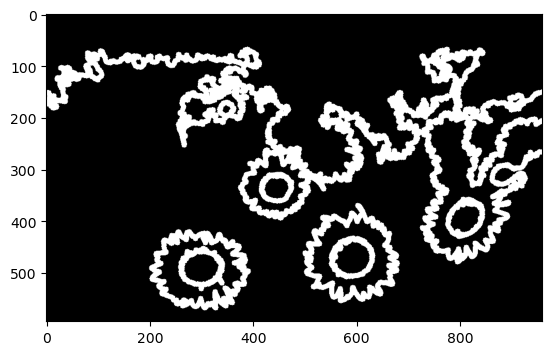

In [36]:
# Find the gradient of the original image image
#  I had to do some conversion here to use the disk strucutral element
grad_bw = ski.filters.rank.gradient(ski.util.img_as_uint(bw), ski.morphology.disk(5))
plt.imshow(grad_bw, cmap='gray')

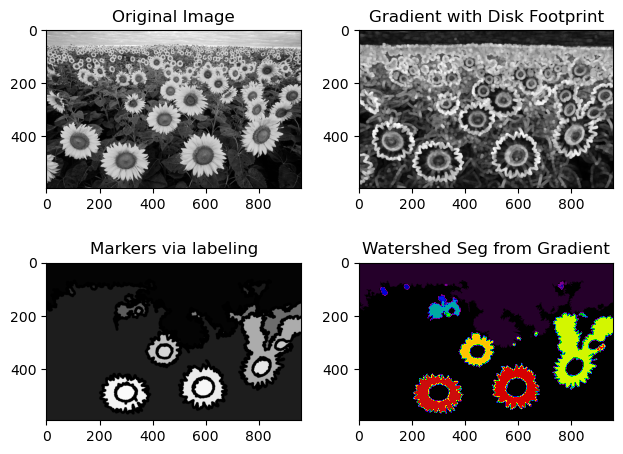

In [44]:
# Apply a marker-based watershed segmentation
# Find plateaus in the image

# Some gradient threshold level
thresh_level = 10

markers = label(grad_bw < thresh_level)[0]
# Run a watershed using the gradient and the markers
labels = ski.segmentation.watershed(grad_bw, markers, mask=bw)

# Plot it all out, the grayscale image, the mask, the markers, and the labels created by the watershed
fig, ax = plt.subplots(2,2)
plt.tight_layout()


ax[0,0].set_title('Original Image')
ax[0,0].imshow(imblk, cmap=plt.cm.gray)

ax[0,1].set_title('Gradient with Disk Footprint')
ax[0,1].imshow(grad_disk, cmap=plt.cm.gray)

ax[1,0].set_title('Markers via labeling')
ax[1,0].imshow(markers, cmap=plt.cm.gray)

ax[1,1].set_title('Watershed Seg from Gradient')
ax[1,1].imshow(labels, cmap=plt.cm.nipy_spectral) # I would like some color now

The markers where the threshold level was less than 10 found some flowers but ultimatly bled the sky into the middle of the field.  This is an issue with the 'bw' preproccessed image that I was unable to resolve.